In [1]:
%%capture
# import sys

# if 'google.colab' in sys.modules:
#     # Install packages in Colab
#     !pip install category_encoders==2.*
#     !pip install eli5
#     !pip install pandas-profiling==2.*
#     !pip install pdpbox
#     !pip install shap

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

# Import Data
________

In [4]:
csv_names = ['Table data 2018.csv', 'Table data 2019.csv', 'Table data 2020.csv']
path = '/content/drive/MyDrive/Ai07_S2_Project/Data_youtube/'

df = pd.concat((pd.read_csv(path+csv_names[0])[1:-1], 
                pd.read_csv(path+csv_names[1])[1:-1],
               pd.read_csv(path+csv_names[2])[1:-1])).reset_index(drop=True)

df.columns = df.columns.str.replace(' ', '_')
col_map ={'Av­er­age_views_per_view­er':'Average_views_per_viewer',
          'Unique_view­ers':'Unique_viewers',
          'Av­er­age_per­cent­age_viewed_(%)':'Average_viewed',
          'Im­pres­sions':'Impressions',
          'Dis\xadlikes':'Dislikes',
          'Sub­scribers_lost':'Subscribers_lost',
          'Sub­scribers_gained':'Subscribers_gained',
          'Videos_pub­lished':'Videos_published',
          'Videos_ad­ded':'Videos_added', 
          'Sub­scribers':'Subscribers',
          'Im­pres­sions_click-through_rate_(%)':'Click_rate',
          'Com­ments_ad­ded':'Comments',
          'Watch_time_(hours)':'Watch_hours',
          'Av­er­age_view_dur­a­tion':'Average_view_sec',
          'Your_es­tim­ated_rev­en­ue_(USD)':'Revenue'}
df = df.rename(columns=col_map)
df = df.drop(['Likes_(vs._dis­likes)_(%)', 
              'Videos_added', 
              'Subscribers_lost',
              'Subscribers_gained'], axis=1)

print("2018-2020 YouTuber 'PoohinKorea' Daily Data")
print("="*45)
print('Data Size: ', df.shape)
print('Null Values: ', df.isna().sum().sum())
print('Data types: ', df.dtypes.reset_index().groupby(0).count().reset_index().values.tolist())
df.head(2)

2018-2020 YouTuber 'PoohinKorea' Daily Data
Data Size:  (1132, 16)
Null Values:  141
Data types:  [[dtype('float64'), 14], [dtype('O'), 2]]


,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,0:01:51,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,NaN,4.0,37.0,0.9575,0:01:33,0.0


# EDA
_______

In [5]:
df.select_dtypes(include=('object')).head(2)

,Date,Average_view_sec
0,2018-08-21,0:01:51
1,2018-08-22,0:01:33


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Average_view_sec'] = pd.to_timedelta(df['Average_view_sec']).dt.seconds

In [7]:
df.isna().sum().reset_index().style.highlight_min()

,index,0
0,Date,0
1,Average_views_per_viewer,0
2,Unique_viewers,0
3,Click_rate,0
4,Impressions,0
5,Comments,0
6,Shares,0
7,Dislikes,0
8,Likes,0
9,Average_viewed,0


In [8]:
df.Videos_published.value_counts(dropna=False)

0.0    869
NaN    141
1.0    120
2.0      1
3.0      1
Name: Videos_published, dtype: int64

In [9]:
df.Videos_published = df.Videos_published.fillna(0.0, axis=0)
df.isna().sum().sum()

0

In [10]:
df.columns

Index(['Date', 'Average_views_per_viewer', 'Unique_viewers', 'Click_rate',
       'Impressions', 'Comments', 'Shares', 'Dislikes', 'Likes',
       'Average_viewed', 'Videos_published', 'Subscribers', 'Views',
       'Watch_hours', 'Average_view_sec', 'Revenue'],
      dtype='object')

In [11]:
df.head(2)

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93,0.0


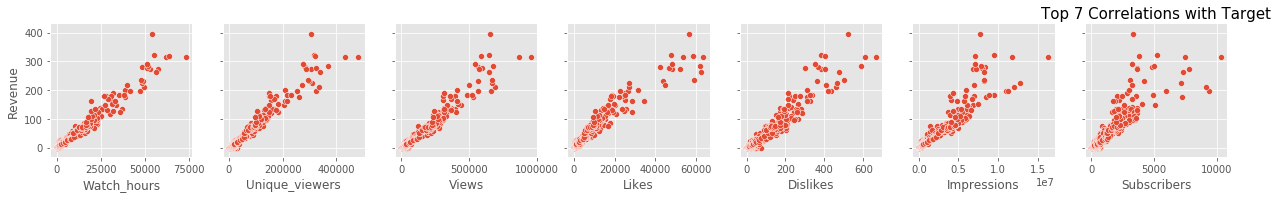

In [12]:
top_corr_name = df.corr()['Revenue'].sort_values(ascending=False).reset_index()['index'][:8].values
sns.pairplot(df[top_corr_name], x_vars=top_corr_name[1:], y_vars=top_corr_name[0])
plt.title('Top 7 Correlations with Target', fontsize=15)
plt.show()

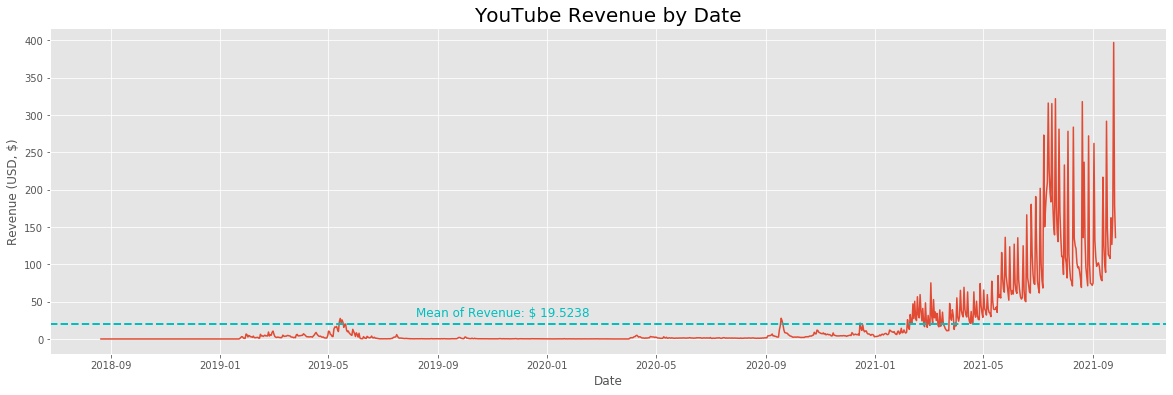

In [13]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x='Date', y='Revenue')
plt.axhline(df.Revenue.mean(), color='c', linestyle='--', linewidth=2)
plt.annotate('Mean of Revenue: $ {}'.format(round(df.Revenue.mean(),4)), 
             (df.Date[350], 30), 
             fontsize=12, 
             color='c')
plt.title('YouTube Revenue by Date', fontsize=20)
plt.ylabel('Revenue (USD, $)')
plt.show()

In [14]:
df.corr()['Revenue'].sort_values(ascending=False).reset_index()[1:].style.bar(align='mid')

,index,Revenue
1,Watch_hours,0.984514
2,Unique_viewers,0.978712
3,Views,0.976545
4,Likes,0.964728
5,Dislikes,0.963711
6,Impressions,0.941682
7,Subscribers,0.907303
8,Comments,0.830628
9,Shares,0.812967
10,Average_view_sec,0.646830


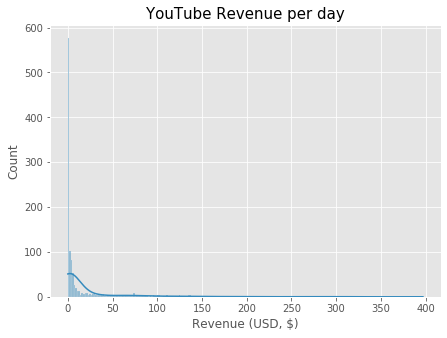

In [15]:
plt.figure(figsize=(7,5))
sns.histplot(df['Revenue'], kde=True)
plt.title('YouTube Revenue per day', fontsize=15)
plt.xlabel('Revenue (USD, $)')
plt.show()

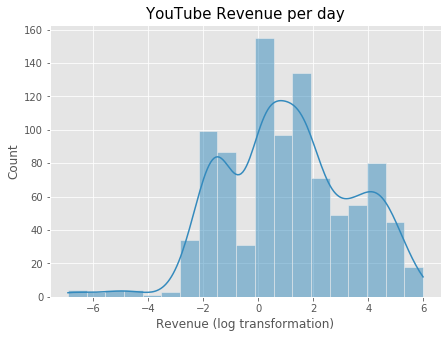

In [16]:
plt.figure(figsize=(7,5))
sns.histplot(np.log(df['Revenue']), kde=True)
plt.title('YouTube Revenue per day', fontsize=15)
plt.xlabel('Revenue (log transformation)')
plt.show()

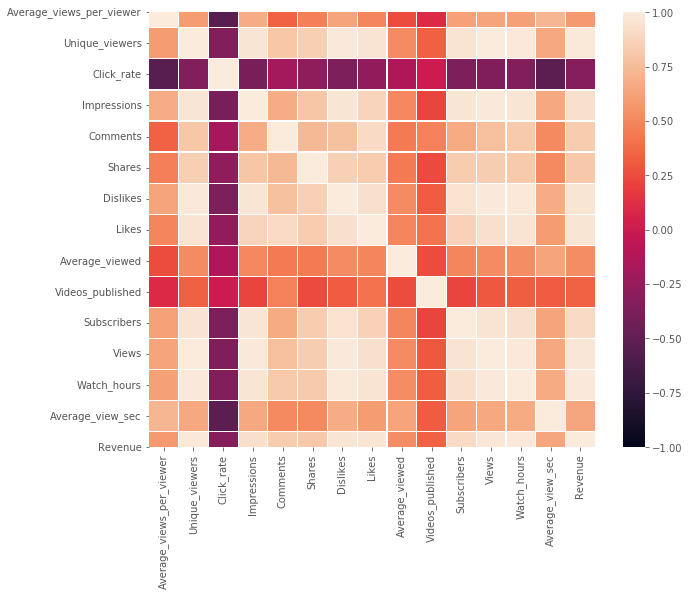

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, linewidths=.2)
plt.show()

In [18]:
df.describe().loc[['mean', 'std', 'min', '50%', 'max']]

,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
mean,1.627234,25396.726148,6.568640,8.335591e+05,224.119258,123.036219,39.393993,2788.837456,28.777359,0.110424,507.715548,51973.775618,3914.129724,183.098057,19.523801
std,0.325841,54910.406132,2.246657,1.878691e+06,737.013531,333.979856,81.494291,7468.640081,6.136640,0.324639,1068.715498,115197.396189,9274.014141,59.761655,46.704338
min,1.000000,8.000000,3.520000,4.400000e+01,0.000000,0.000000,-1.000000,-1.000000,10.950000,0.000000,-8.000000,8.000000,0.115200,51.000000,0.000000
50%,1.556750,4115.000000,6.110000,6.886200e+04,28.000000,22.000000,6.000000,257.500000,28.095000,0.000000,118.000000,6450.500000,297.368850,176.000000,1.582000
max,2.615800,482254.000000,23.140000,1.632350e+07,11582.000000,6513.000000,664.000000,63543.000000,62.190000,3.000000,10297.000000,954121.000000,73470.409300,395.000000,397.066000


In [19]:
df.to_csv('/content/drive/MyDrive/Ai07_S2_Project/Data_youtube/2018-2019 Data.csv')

# Feature Engineering
_________


In [20]:
df.head(2)

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93,0.0


In [21]:
Video_pub = df.Videos_published.values.tolist()
Videos = []
count = 0
for v in Video_pub:
    count += v
    Videos.append(count)

In [22]:
df['Videos'] = Videos
df.head(2)

,Date,Average_views_per_viewer,Unique_viewers,Click_rate,Impressions,Comments,Shares,Dislikes,Likes,Average_viewed,Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Revenue,Videos
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111,0.0,1.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93,0.0,1.0


In [23]:
df.Videos_published.value_counts()

0.0    1010
1.0     120
2.0       1
3.0       1
Name: Videos_published, dtype: int64

In [24]:
df['Videos_published'] = df.Videos_published.mask((df.Videos_published>0), 1).astype('int')

### Check Variance Inflation Factor for Colinearity

In [25]:
from sklearn.linear_model import LinearRegression

def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [26]:
df.corr()['Revenue'].sort_values(ascending=False).reset_index()

,index,Revenue
0,Revenue,1.000000
1,Watch_hours,0.984514
2,Unique_viewers,0.978712
3,Views,0.976545
4,Likes,0.964728
5,Dislikes,0.963711
6,Impressions,0.941682
7,Subscribers,0.907303
8,Comments,0.830628
9,Shares,0.812967


In [27]:
df.corr()['Revenue'].sort_values(ascending=False).reset_index()['index'][1:14].values

array(['Watch_hours', 'Unique_viewers', 'Views', 'Likes', 'Dislikes',
       'Impressions', 'Subscribers', 'Comments', 'Shares', 'Videos',
       'Average_view_sec', 'Average_views_per_viewer', 'Average_viewed'],
      dtype=object)

In [28]:
features_chosen=[
                #  'Watch_hours', 
                #  'Unique_viewers', 
                #  'Views', 
                #  'Likes', 
                #  'Dislikes',
                #  'Impressions', 
                 'Subscribers', 
                 'Comments', 
                 'Shares',
                 'Videos',
                 'Average_view_sec', 
                #  'Average_views_per_viewer', 
                 'Average_viewed'
                 ]
calculate_vif(df.iloc[:,1:], features=features_chosen)

,VIF,Tolerance
Subscribers,4.479315,0.223248
Comments,2.359590,0.423803
Shares,4.092559,0.244346
Videos,4.179367,0.239271
Average_view_sec,4.415762,0.226461
Average_viewed,1.961287,0.509869


In [29]:
cols_remove = ['Average_views_per_viewer', 
                'Watch_hours', 
                'Unique_viewers', 
                'Views', 
                'Likes', 
                'Dislikes',
                'Impressions', 
                'Date']

df_new = df.copy()
df_new = df_new.drop(cols_remove, axis=1)
print('New Data Shape: ', df_new.shape)
df_new.head(2)

New Data Shape:  (1132, 9)


,Click_rate,Comments,Shares,Average_viewed,Videos_published,Subscribers,Average_view_sec,Revenue,Videos
0,7.38,2.0,1.0,53.59,1,5.0,111,0.0,1.0
1,23.14,3.0,0.0,44.58,0,4.0,93,0.0,1.0


In [30]:
df_new.corr()['Revenue']

Click_rate         -0.322937
Comments            0.830628
Shares              0.812967
Average_viewed      0.530312
Videos_published    0.339937
Subscribers         0.907303
Average_view_sec    0.646830
Revenue             1.000000
Videos              0.721154
Name: Revenue, dtype: float64

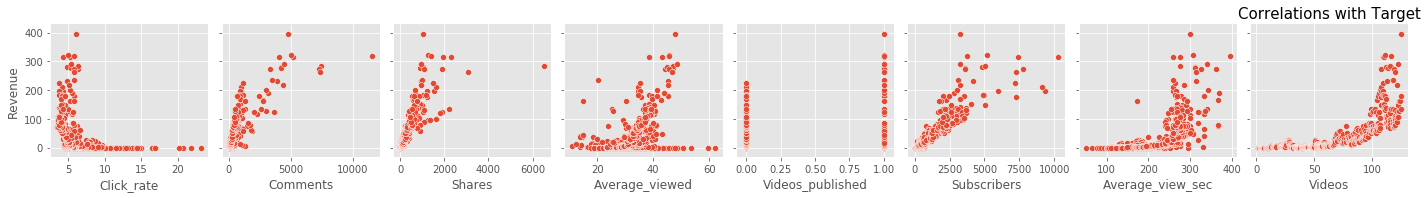

In [31]:
sns.pairplot(df_new, x_vars=df_new.columns.drop('Revenue'), y_vars=['Revenue'])
plt.title('Correlations with Target', fontsize=15)
plt.show()

# Split Data
_________

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
train, test = train_test_split(df_new, test_size=0.2, random_state=33)

train.shape, test.shape

((905, 9), (227, 9))

In [34]:
target = 'Revenue'

X_train = train.drop(target, axis=1)
y_train = train[target]
X_test = test.drop(target, axis=1)
y_test = test[target]

X_train.shape, y_train.shape

((905, 8), (905,))

# BaseLine Model
_____

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
def evaluate(title, y, y_):
    mae = mean_absolute_error(y, y_)
    rmse = mean_squared_error(y, y_)**0.5
    r2 = r2_score(y, y_)
    print('*{} Result*'.format(title))
    print('='*50)
    print('MAE Score: $', mae)
    print('RMSE Score: $', rmse)
    print('R2 Score: ', r2)
    print()

### Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [38]:
y_train

559       0.094
505       0.161
1053    175.732
308       0.568
729       1.069
         ...   
57        0.000
658       1.387
578       0.000
391       0.361
1044     77.151
Name: Revenue, Length: 905, dtype: float64

In [39]:
pipe_lin = make_pipeline(
    StandardScaler(),
    LinearRegression(n_jobs=-1)
)

pipe_lin.fit(X_train, y_train)
y_pred = np.exp(pipe_lin.predict(X_test))
evaluate('Linear Regression', y_test, y_pred)

*Linear Regression Result*
MAE Score: $ 1.4958501325686436e+112
RMSE Score: $ 2.2537254702757782e+113
R2 Score:  -2.4341965405735807e+223



### Log Transformed Linear Regression

In [40]:
from sklearn.compose import TransformedTargetRegressor

In [41]:
tt_lin = TransformedTargetRegressor(regressor=pipe_lin,
                                func=np.log1p, inverse_func=np.expm1)

tt_lin.fit(X_train, y_train)
y_pred = tt_lin.predict(X_test)
evaluate('Log Transformed Linear Regression', y_test, y_pred)

*Log Transformed Linear Regression Result*
MAE Score: $ 5.7191392327673185
RMSE Score: $ 13.364582142033845
R2 Score:  0.9144018488442192



# Model Selection
_____

### Ridge

In [42]:
pipe_ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=np.arange(6.9, 8.0, 0.01), cv=5)
)

tt_ridge = TransformedTargetRegressor(regressor=pipe_ridge,
                                func=np.log1p, inverse_func=np.expm1)

tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
print('Best alpha: ', tt_ridge.regressor_.named_steps['ridgecv'].alpha_)
evaluate('Log Transformed Ridge', y_test, y_pred)

Best alpha:  7.39999999999999
*Log Transformed Ridge Result*
MAE Score: $ 5.695617234076975
RMSE Score: $ 13.363390724661286
R2 Score:  0.9144171098643541



### Lasso

In [43]:
pipe_lasso = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=np.arange(0, 0.02, 0.001), cv=5, random_state=33)
)

tt_lasso = TransformedTargetRegressor(regressor=pipe_lasso,
                                func=np.log1p, inverse_func=np.expm1)

tt_lasso.fit(X_train, y_train)
y_pred = tt_lasso.predict(X_test)
print('Best alpha: ', tt_lasso.regressor_.named_steps['lassocv'].alpha_)
evaluate('Log Transformed Lasso', y_test, y_pred)

Best alpha:  0.014
*Log Transformed Lasso Result*
MAE Score: $ 6.287436502470175
RMSE Score: $ 14.808744032215655
R2 Score:  0.8949030607871151



### ElasticNet

In [44]:
from sklearn.linear_model import ElasticNetCV

In [45]:
pipe_elnet = make_pipeline(
    StandardScaler(),
    ElasticNetCV(n_jobs=-1, cv=5, random_state=33)
)

tt_elnet = TransformedTargetRegressor(regressor=pipe_elnet,
                                func=np.log1p, inverse_func=np.expm1)

tt_elnet.fit(X_train, y_train)
y_pred = tt_elnet.predict(X_test)
evaluate('Log Transformed ElasticNet', y_test, y_pred)

*Log Transformed ElasticNet Result*
MAE Score: $ 5.872001491239751
RMSE Score: $ 13.845040830826955
R2 Score:  0.9081366884915127



### RandomForest Regressor

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
pipe_rfreg = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=33)
)

tt_rfreg = TransformedTargetRegressor(regressor=pipe_rfreg,
                                func=np.log1p, inverse_func=np.expm1)

tt_rfreg.fit(X_train, y_train)
y_pred = tt_rfreg.predict(X_test)
evaluate('Log Transformed RandomForest Regressor', y_test, y_pred)

*Log Transformed RandomForest Regressor Result*
MAE Score: $ 2.660706629340559
RMSE Score: $ 7.627155055698575
R2 Score:  0.9721208989485217



### XGB Regressor

In [48]:
from xgboost import XGBRegressor

In [49]:
pipe_xgb = make_pipeline(
    StandardScaler(),
    XGBRegressor(learning_rate=0.1,
                  n_estimators=500,
                  n_jobs=-1,
                  random_state=33)
)

tt_xgb = TransformedTargetRegressor(regressor=pipe_xgb,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train)
y_pred = tt_xgb.predict(X_test)
evaluate('Log Transformed XGB Regressor', y_test, y_pred)

[08:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*Log Transformed XGB Regressor Result*
MAE Score: $ 2.313098482994922
RMSE Score: $ 6.171336155448128
R2 Score:  0.9817479343707034



### Light Gradient Boost Machine Regressor

In [50]:
from lightgbm import LGBMRegressor

In [51]:
pipe_lgb = make_pipeline(
    StandardScaler(),
    LGBMRegressor(learning_rate=0.1,
                  n_estimators=500,
                  n_jobs=-1,
                  random_state=33)
)

tt_lgb = TransformedTargetRegressor(regressor=pipe_lgb,
                                func=np.log1p, inverse_func=np.expm1)

tt_lgb.fit(X_train, y_train)
y_pred = tt_lgb.predict(X_test)
evaluate('Log Transformed Light GBM Regressor', y_test, y_pred)

*Log Transformed Light GBM Regressor Result*
MAE Score: $ 2.9055230779799035
RMSE Score: $ 8.744761814650069
R2 Score:  0.9633520585498996



# Visualization
____

### LinearRegression, Ridge, Lasso, ElasticNet

In [52]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
    return coef

def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(20, 6), nrows=1, ncols=4)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef = get_top_bottom_coef(model)
        axs[i_num].set_title(model.__class__.__name__+ ' Coefficients', size=20)
        axs[i_num].tick_params(axis='y', direction='in', pad=0)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(13)
        sns.barplot(x=coef.values,
                   y=coef.index, ax=axs[i_num])
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.8, 
                    hspace=0.4)

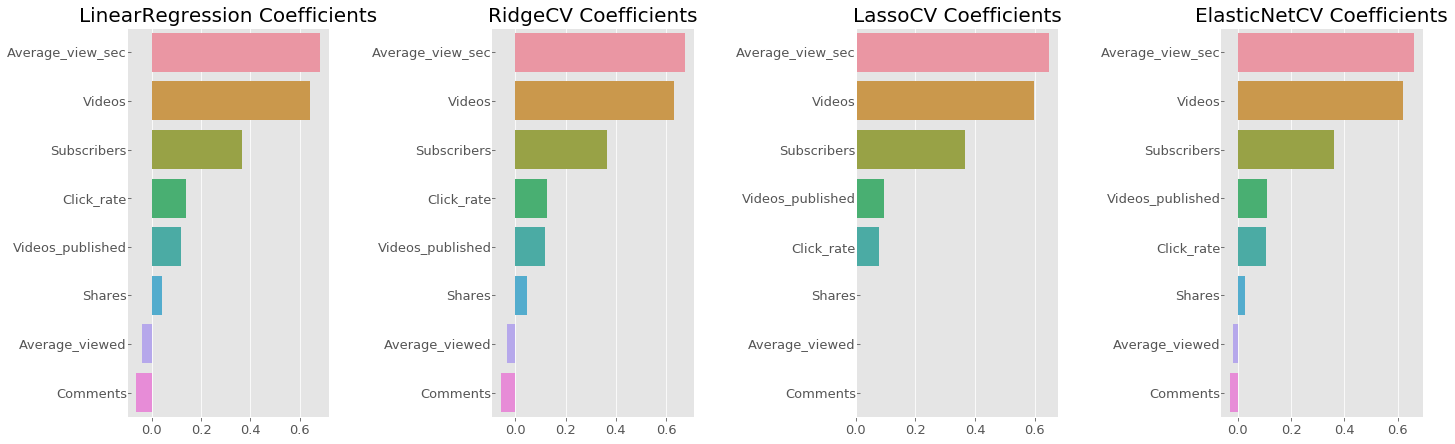

In [53]:
lin = tt_lin.regressor_.named_steps['linearregression']
ridge = tt_ridge.regressor_.named_steps['ridgecv']
lasso = tt_lasso.regressor_.named_steps['lassocv']
elnet = tt_elnet.regressor_.named_steps['elasticnetcv']
models = [lin, ridge, lasso, elnet]

visualize_coefficient(models)

### Tree-based Regressor

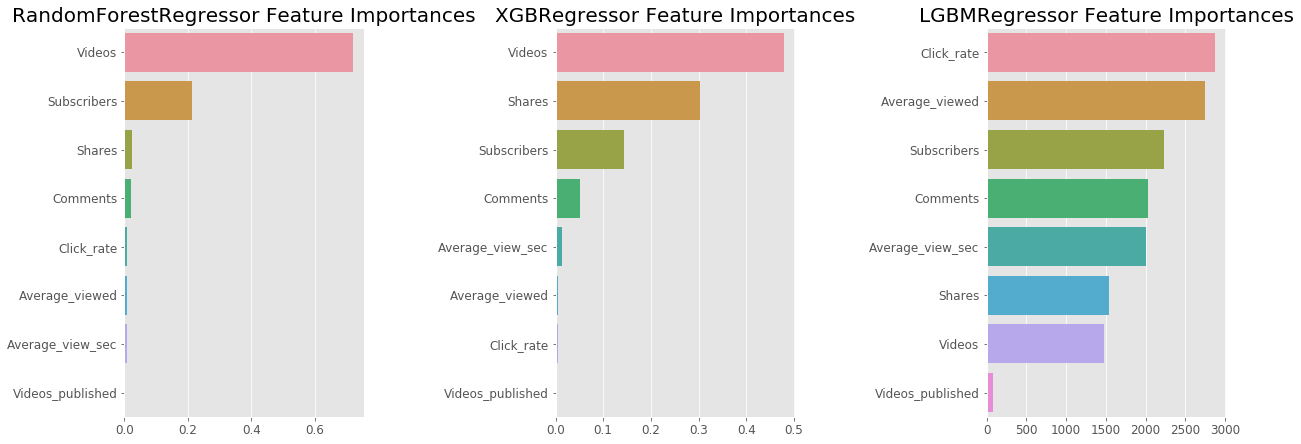

In [54]:
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
    ftr_top = ftr_importances.sort_values(ascending=False)
    return ftr_top

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(17,6), nrows=1, ncols=3)
    fig.tight_layout() 
    for i_num, model in enumerate(models):
        ftr_top = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=20)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(12)
        sns.barplot(x=ftr_top.values, y=ftr_top.index , ax=axs[i_num])
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.8, 
                    hspace=0.4)

rf = tt_rfreg.regressor_.named_steps['randomforestregressor']
xgb = tt_xgb.regressor_.named_steps['xgbregressor']
lgbm = tt_lgb.regressor_.named_steps['lgbmregressor']

models = [rf, xgb, lgbm]
visualize_ftr_importances(models)

In [55]:
y_pred = tt_rfreg.predict(X_test)*0.3 + tt_xgb.predict(X_test)*0.7
evaluate('[RF + XGB]', y_test, y_pred)

*[RF + XGB] Result*
MAE Score: $ 2.245925860820127
RMSE Score: $ 6.036983911529442
R2 Score:  0.9825339921067112



# Hyperparameters
_____

In [56]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [57]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [58]:
rf_reg = RandomForestRegressor(n_estimators=100,
                               n_jobs=-1,
                               random_state=33)

xgb_reg = XGBRegressor(n_estimators=100,
                       n_jobs=-1,
                       random_state=33,
                       seed=33)

lgb_reg = LGBMRegressor(n_estimators=100,
                        n_jobs=-1,
                        random_state=33)

In [59]:
def randcv(estimator, params):
    randcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions=params,
                                n_iter=5,
                                scoring='neg_root_mean_squared_error',
                                cv=3,
                                random_state=33,
                                n_jobs=-1)

    tt = TransformedTargetRegressor(regressor=randcv,
                                func=np.log1p, inverse_func=np.expm1)

    tt.fit(X_train, y_train)
    y_pred = tt.predict(X_test)

    print('Best Params: ', tt.regressor_.best_params_)
    evaluate(estimator.__class__.__name__, y_test, y_pred)

    return tt.regressor_.best_estimator_

In [60]:
def gridcv(estimator, params):
    gridcv = GridSearchCV(estimator=estimator,
                          param_grid=params,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          n_jobs=-1)

    tt = TransformedTargetRegressor(regressor=gridcv,
                                func=np.log1p, inverse_func=np.expm1)

    tt.fit(X_train, y_train)
    y_pred = tt.predict(X_test)

    print('Best Params: ', tt.regressor_.best_params_)
    evaluate(estimator.__class__.__name__, y_test, y_pred)
    
    return tt.regressor_.best_estimator_

### RandomForest Hyperparameters

In [61]:
params_rf = {'max_depth': [18], 
             'min_samples_split': [6], 
             'min_samples_leaf': [1]
             }
# randcv_rf = randcv(rf_reg, params_rf)
gridcv_rf = gridcv(rf_reg, params_rf)

Best Params:  {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 6}
*RandomForestRegressor Result*
MAE Score: $ 2.634098456337518
RMSE Score: $ 7.718590228286192
R2 Score:  0.9714484568583275



In [62]:
pipe_rfreg = make_pipeline(
    # StandardScaler(),
    RandomForestRegressor(n_estimators=100,
                          min_samples_split=6,
                          min_samples_leaf=1,
                          max_depth=18, 
                          n_jobs=-1,
                          oob_score=True, 
                          random_state=33)
)

tt_rfreg = TransformedTargetRegressor(regressor=pipe_rfreg,
                                func=np.log1p, inverse_func=np.expm1)

tt_rfreg.fit(X_train, y_train)
y_pred = tt_rfreg.predict(X_test)
print('OOB Score: ', tt_rfreg.regressor_.named_steps['randomforestregressor'].oob_score_)
print('='*50)
evaluate('Log Transformed RandomForest Regressor for Training Set', y_train, tt_rfreg.predict(X_train))
evaluate('Log Transformed RandomForest Regressor for Test Set', y_test, y_pred)

OOB Score:  0.9851013051449238
*Log Transformed RandomForest Regressor for Training Set Result*
MAE Score: $ 1.4354182196605327
RMSE Score: $ 5.169469490375792
R2 Score:  0.9878651911862931

*Log Transformed RandomForest Regressor for Test Set Result*
MAE Score: $ 2.634098456337518
RMSE Score: $ 7.718590228286195
R2 Score:  0.9714484568583275



### XGBoost Hyperparameters

In [63]:
params_xgb = {
              'max_depth':[3], 
              'learning_rate':[0.001, 0.01, 0.1, 0.15], 
            }

# randcv(xgb_reg, params_xgb)
gridcv(xgb_reg, params_xgb)

[08:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Params:  {'learning_rate': 0.15, 'max_depth': 3}
*XGBRegressor Result*
MAE Score: $ 2.3652343370392566
RMSE Score: $ 6.092402464119675
R2 Score:  0.9822118499036135



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=33,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=33,
             silent=None, subsample=1, verbosity=1)

In [64]:
xgb_reg = XGBRegressor(n_estimators=1000,
                       max_depth=3,
                       n_jobs=-1,
                       random_state=33,
                       seed=33)

tt_xgb = TransformedTargetRegressor(regressor=xgb_reg,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train,
        verbose=False,
        early_stopping_rounds=100,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse')
y_pred = tt_xgb.predict(X_test)
evaluate('Log Transformed XGB Regressor for Training Set', y_train, tt_xgb.predict(X_train))
evaluate('Log Transformed XGB Regressor for Test Set', y_test, y_pred)

[08:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*Log Transformed XGB Regressor for Training Set Result*
MAE Score: $ 1.1198290462328389
RMSE Score: $ 2.914513790889545
R2 Score:  0.9961427906164747

*Log Transformed XGB Regressor for Test Set Result*
MAE Score: $ 2.5427815257164728
RMSE Score: $ 7.064257159793844
R2 Score:  0.9760841062093667



### LightGBM Hyperparameters

In [65]:
params_lgb = {
              'num_leaves':[29], 
              'max_depth':[-1], 
              'learning_rate':[0.1], 
              }

# randcv(lgb_reg, params_lgb)
gridcv(lgb_reg, params_lgb)

Best Params:  {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 29}
*LGBMRegressor Result*
MAE Score: $ 2.92466319011833
RMSE Score: $ 9.183561032501144
R2 Score:  0.9595819042555159



LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=29, objective=None,
              random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [66]:
lgb_reg = LGBMRegressor(n_estimators=1000,
                        num_leaves=29,
                        max_depth=-1,
                        learning_rate=0.1,
                        n_jobs=-1,
                        objective='regression',
                        random_state=33)

tt_lgb = TransformedTargetRegressor(regressor=lgb_reg,
                                func=np.log1p, inverse_func=np.expm1)

tt_lgb.fit(X_train, y_train,
        verbose=False,
        early_stopping_rounds=100,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse')
y_pred = tt_lgb.predict(X_test)
evaluate('Log Transformed Light GBM Regressor for Training Set', y_train, tt_lgb.predict(X_train))
evaluate('Log Transformed Light GBM Regressor for Test Set', y_test, y_pred)

*Log Transformed Light GBM Regressor for Training Set Result*
MAE Score: $ 0.3937343715497904
RMSE Score: $ 2.045457796478515
R2 Score:  0.9981001381075302

*Log Transformed Light GBM Regressor for Test Set Result*
MAE Score: $ 2.6756230504722
RMSE Score: $ 8.387139645460842
R2 Score:  0.9662882449043281



# Result
________

In [67]:
import eli5
from eli5.sklearn import PermutationImportance

In [68]:
from IPython.display import display

# Permutation Importance
prm_imps = PermutationImportance(tt_xgb,
                                 scoring='neg_root_mean_squared_error',
                                 n_iter=5,
                                 random_state=33)

prm_imps.fit(X_train, y_train)
print('Permutation Importance')
display(eli5.show_weights(
    prm_imps,
    top=None,
    feature_names=X_train.columns.to_list()
))

Permutation Importance


Weight,Feature
34.9363 ± 1.4218,Videos
29.4897 ± 1.9441,Shares
25.5485 ± 1.2835,Comments
22.3339 ± 0.7899,Subscribers
9.3651 ± 1.4855,Average_view_sec
4.0157 ± 0.5516,Average_viewed
3.2854 ± 1.3297,Click_rate
0.0000 ± 0.0000,Videos_published


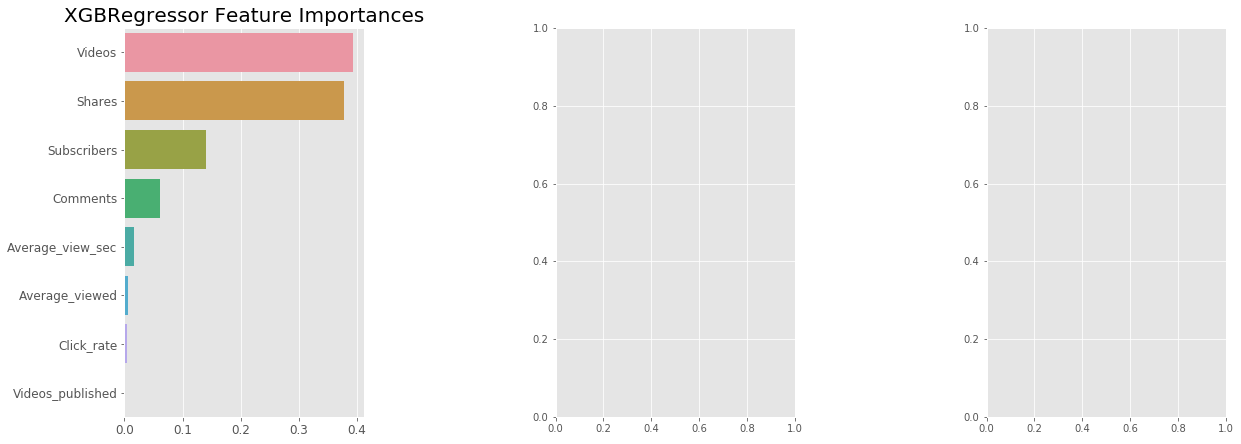

In [69]:
xgb = tt_xgb.regressor_
visualize_ftr_importances([xgb])

In [70]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox import pdp
import shap

In [71]:
def draw_pdp_plot(feature, model, X_val, num_grid_points = 10):
    isolated = pdp_isolate(
        model=model,
        dataset=X_val,
        model_features=X_val.columns,
        feature=feature,
        grid_type='percentile',
        num_grid_points=num_grid_points
    )

    pdp.pdp_plot(isolated, feature)

In [72]:
features = X_train.columns.tolist()
features

['Click_rate',
 'Comments',
 'Shares',
 'Average_viewed',
 'Videos_published',
 'Subscribers',
 'Average_view_sec',
 'Videos']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


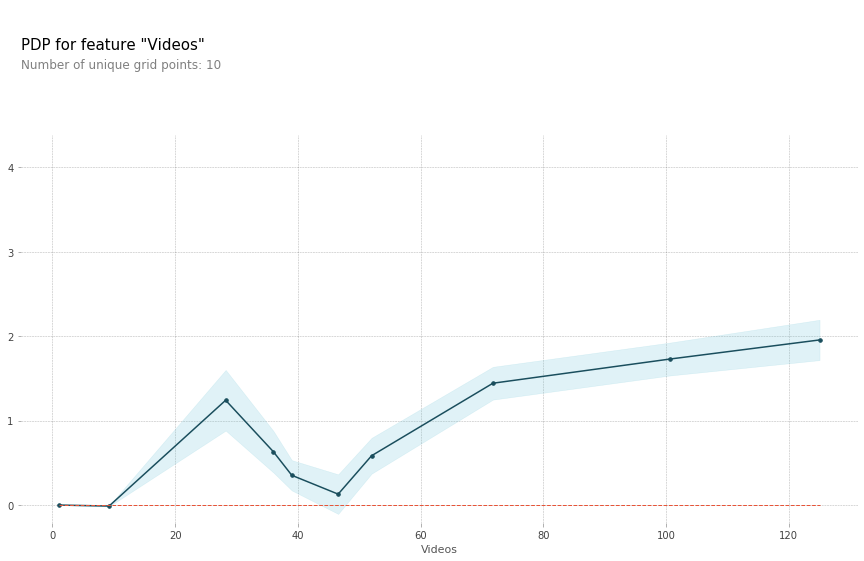

In [73]:
draw_pdp_plot(features[-1], xgb, X_test)

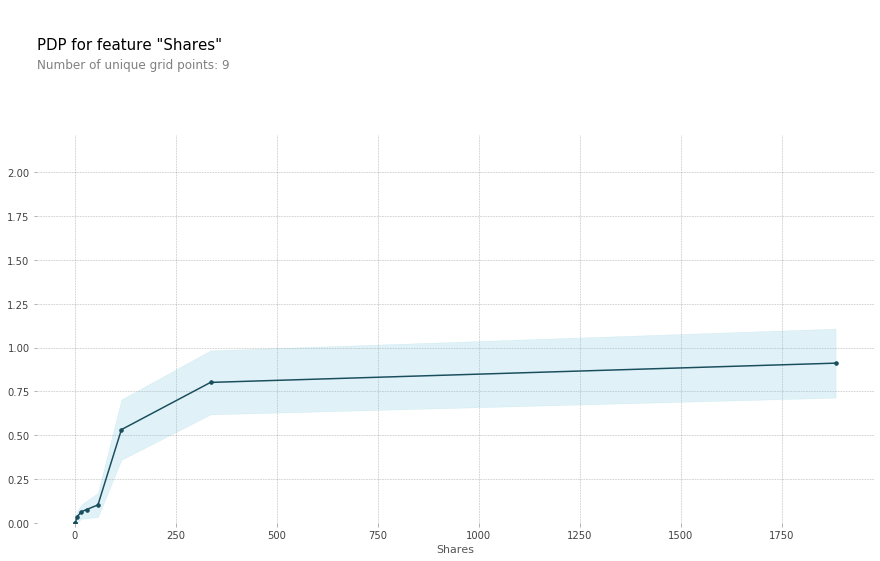

In [74]:
draw_pdp_plot(features[2], xgb, X_test)

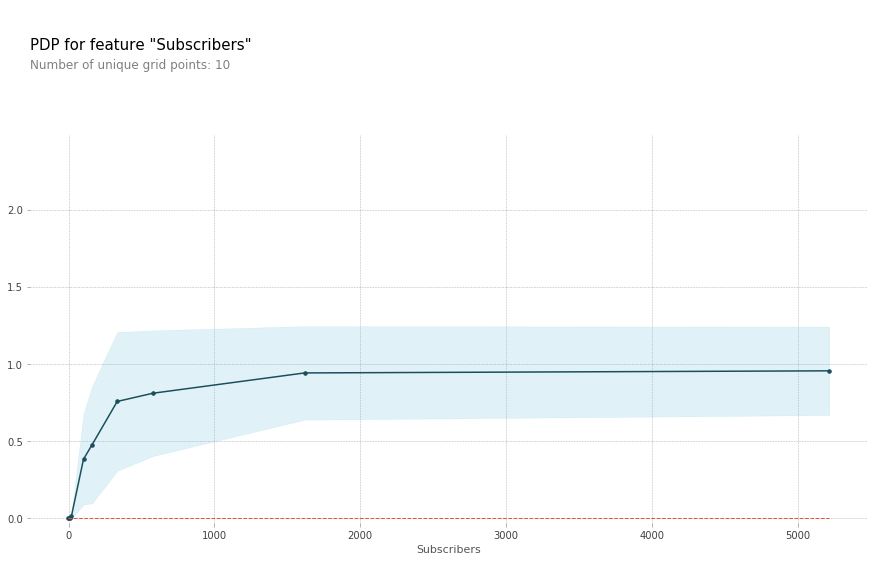

In [75]:
draw_pdp_plot(features[-3], xgb, X_test)

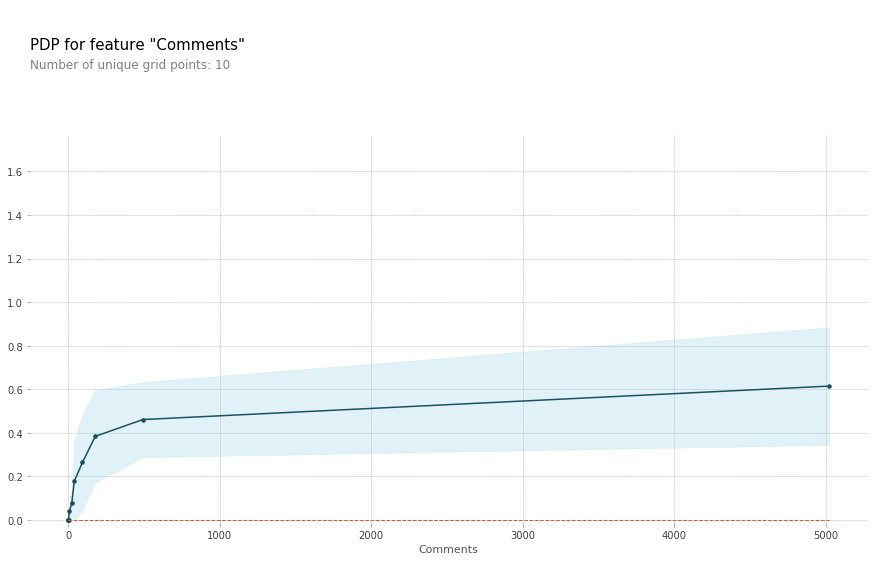

In [76]:
draw_pdp_plot(features[1], xgb, X_test)

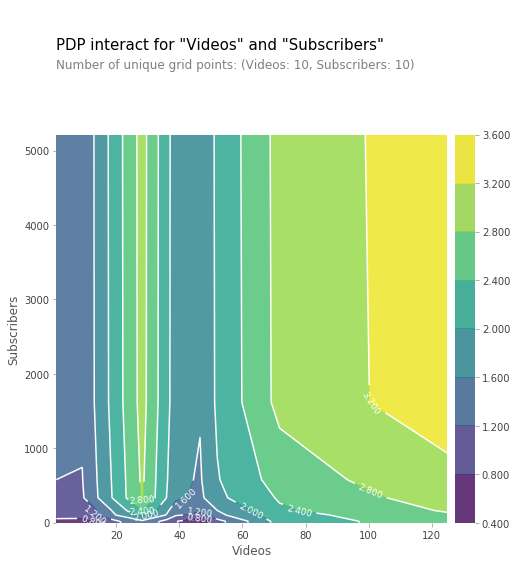

In [77]:
def draw_pdp_interaction(model, features, X_test, plot_type):
    interaction = pdp_interact(
        model=model, 
        dataset=X_test,
        model_features=X_test.columns, 
        features=features
    )

    pdp_interact_plot(interaction, plot_type=plot_type, feature_names=features)

features = ['Videos', 'Subscribers']
draw_pdp_interaction(xgb, features, X_test, 'contour')

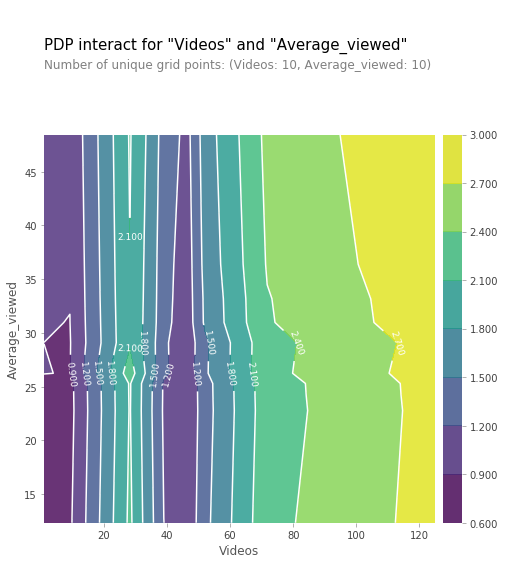

In [78]:
features = ['Videos', 'Average_viewed']
draw_pdp_interaction(xgb, features, X_test, 'contour')

In [79]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [80]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

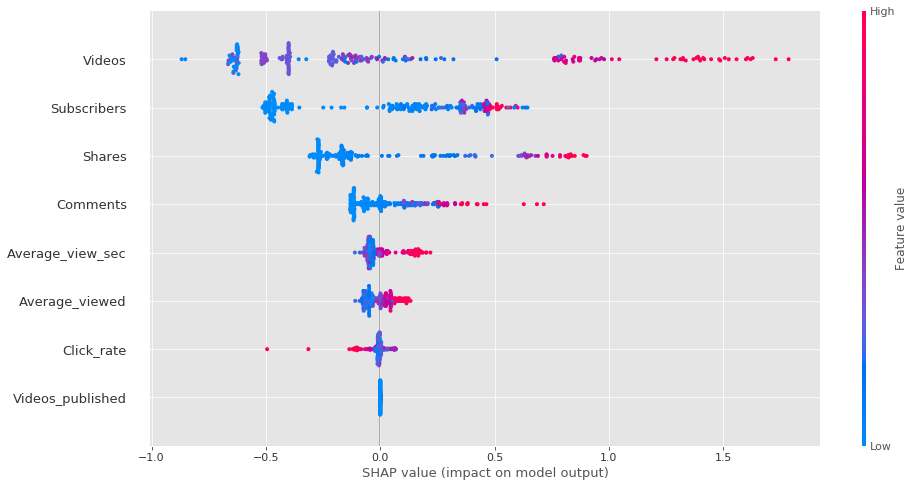

In [81]:
shap.summary_plot(shap_values, X_test, plot_size=(15,8))

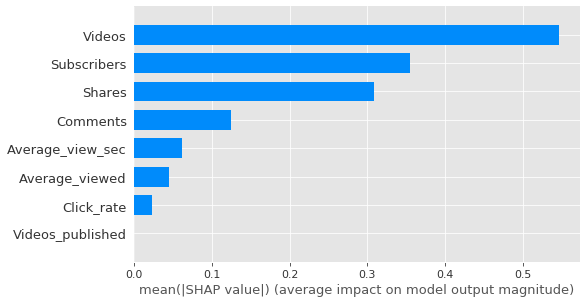

In [82]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [94]:
shap.initjs()
shap.force_plot(explainer.expected_value, explainer.shap_values(X_test.iloc[1]), X_test.iloc[1])

In [121]:
def draw_shap_value(sample):
    explainer = shap.TreeExplainer(xgb)
    shap.initjs()
    samp_df = pd.DataFrame(dict(zip(X_test.columns, np.array(sample).reshape(-1,1))))
    display(shap.force_plot(explainer.expected_value, explainer.shap_values(samp_df.iloc[0]), samp_df.iloc[0]))
    display(samp_df)

In [183]:
sample = [round(random.uniform(0,50),2),
          round(random.uniform(0,12000)),
          round(random.uniform(0,7000)),
          round(random.uniform(10,65),2),
          np.random.binomial(1,0.5,1)[0],
          round(random.uniform(-10,10300)),
          round(random.uniform(50,395)),
          round(random.uniform(1,150))]
draw_shap_value(sample)

,Click_rate,Comments,Shares,Average_viewed,Videos_published,Subscribers,Average_view_sec,Videos
0,16.24,9899.0,5806.0,50.5,1.0,7144.0,63.0,23.0
